## Image Segmentation
This notebook will present the methodology used to tackle the image Segmentation task: Using your fire dataset develop a method of labeling which pixels are associated with the fire (using the segmentation data set).

In [2]:
#Import standard libraries and imageio to read in the images
import imageio.v3 as imageio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


### training dataset
The dataset consists of fire images of size (2160, 3840,3) and mask images of size (2160,3840). Due to limited computational power, it would only be possible to train on a training set of less than 10 images.

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# we take 200 Images and Masks
img_fire = np.zeros((5,2160,3840,3))
img_masks = np.zeros((5,2160,3840))
for i in range(5):
    img_path_fire = 'drive/MyDrive/MiniprojectdataML/Image_Seg/image_'+str(i)+'.jpg'
    img_fire[i]=mpimg.imread(img_path_fire)/255.0

    img_path_masks = 'drive/MyDrive/MiniprojectdataML/Image_Mask/image_'+str(i)+'.png'
    img_masks[i] =mpimg.imread(img_path_masks)
    # normalising img_masks to between 0 and 1
    img_masks[i] = img_masks[i]/np.max(img_masks[i])

In [5]:
import tensorflow as tf

import tensorflow_datasets as tfds



# Data augmentation
data_augmentation1 = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.1),
])


In [5]:

def display(display_list):
  # input: a list of array containing the input image, true mask and predicted mask
  # output: a plot of the images

  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

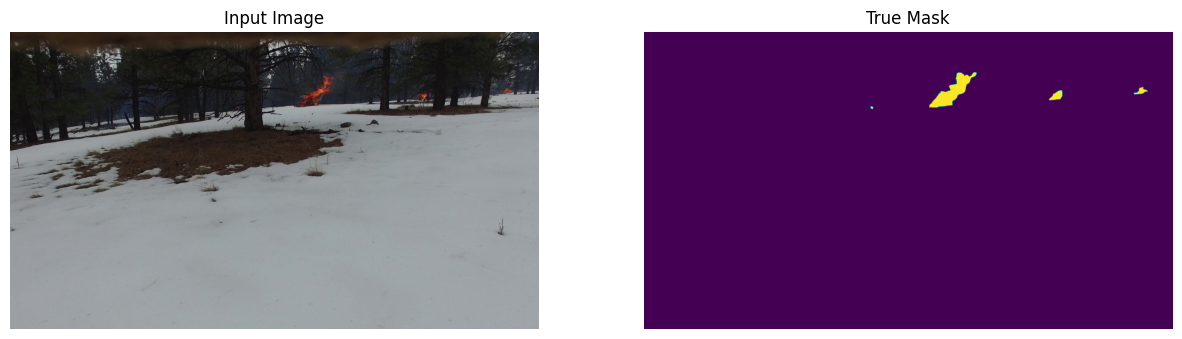

(5, 2160, 3840)


In [6]:
display([img_fire[0],img_masks[0]])
print(img_masks.shape)


In [7]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

# defining the dimension of the images
Img_width= img_masks[0].shape[0]
Img_height = img_masks[0].shape[1]
Img_Channel = img_fire.shape[3]

def model_unet_kaggle(img_hieght, img_width, img_channel, num_classes):
    """
    This function returns a U-Net Model for this binary fire segmentation images:
    Arxiv Link for U-Net: https://arxiv.org/abs/1505.04597
    :param img_hieght: Image Height
    :param img_width: Image Width
    :param img_channel: Number of channels in each image
    :param num_classes: Number of classes based on the Ground Truth Masks
    :return: A convolutional NN based on Tensorflow and Keras
    """
    inputs = Input((img_hieght, img_width, img_channel))
    s = Lambda(lambda x: x / 255)(inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [8]:
model = model_unet_kaggle(Img_width,Img_height,Img_Channel,2)
model.compile(optimizer='adam',  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2160, 3840, 3)]      0         []                            
                                                                                                  
 lambda (Lambda)             (None, 2160, 3840, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 2160, 3840, 16)       448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 2160, 3840, 16)       0         ['conv2d[0][0]']              
                                                                                              

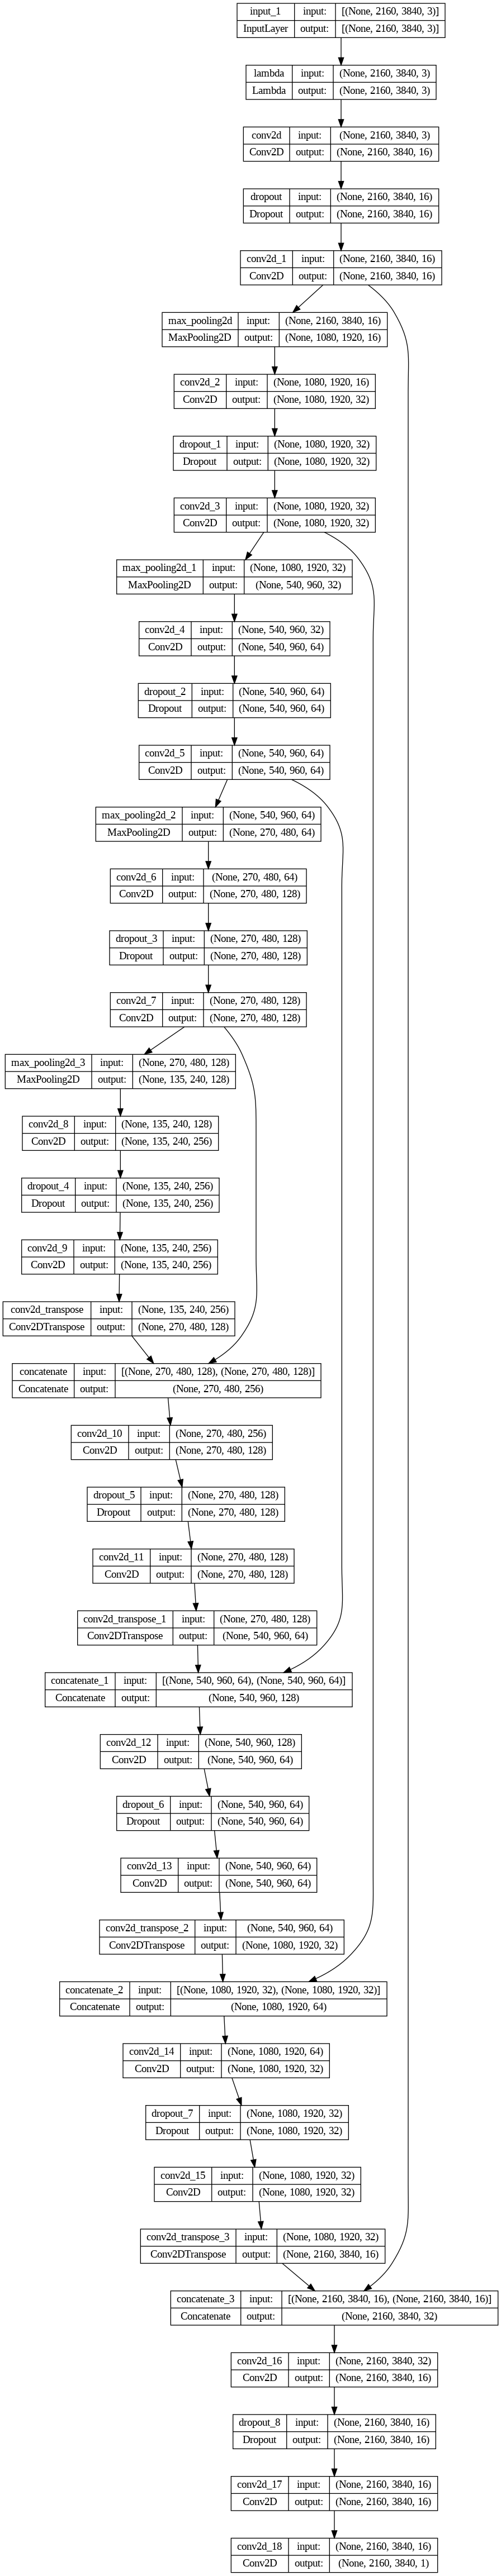

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)

# train and validation dataset
train and validation dataset consists of 2 fire images and 2 fire images respectively along with their corresponding masks

In [10]:
model = model_unet_kaggle(Img_width,Img_height,Img_Channel,2)
model.compile(optimizer='adam',  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',start_from_epoch=1,baseline=0.9,patience=1)
hist = model.fit(img_fire[:2],img_masks[:2], batch_size=3,epochs=60, validation_data=(img_fire[4:],img_masks[4:]),callbacks=[callback])


Epoch 1/60
1/1 [==============================] - 77s 77s/step - loss: 0.6953 - accuracy: 0.4868 - val_loss: 0.6784 - val_accuracy: 0.7395
Epoch 2/60
1/1 [==============================] - 71s 71s/step - loss: 0.6661 - accuracy: 0.6687 - val_loss: 0.5397 - val_accuracy: 0.7345
Epoch 3/60
1/1 [==============================] - 71s 71s/step - loss: 0.5482 - accuracy: 0.7294 - val_loss: 0.3371 - val_accuracy: 0.9958
Epoch 4/60
1/1 [==============================] - 70s 70s/step - loss: 0.3865 - accuracy: 0.8894 - val_loss: 0.2187 - val_accuracy: 0.9960
Epoch 5/60
1/1 [==============================] - 71s 71s/step - loss: 0.2353 - accuracy: 0.9779 - val_loss: 0.0924 - val_accuracy: 0.9961
Epoch 6/60
1/1 [==============================] - 71s 71s/step - loss: 0.1249 - accuracy: 0.9861 - val_loss: 0.0408 - val_accuracy: 0.9961


PCA


1/1 [==============================] - 8s 8s/step


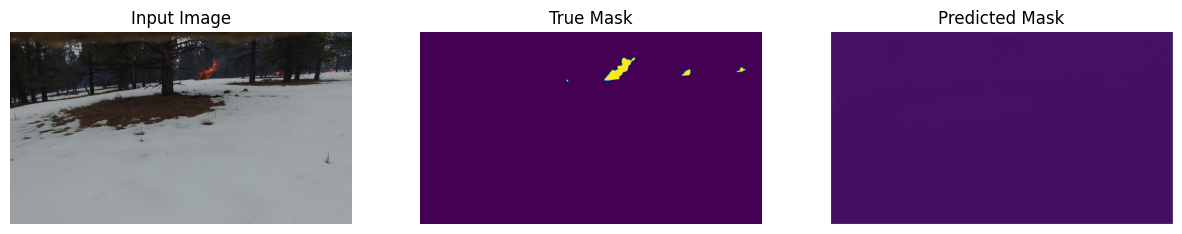

In [14]:
prediction=model.predict(np.array([img_fire[0]]))[0]
display([img_fire[0],img_masks[0],prediction/(np.max(prediction))])


## Comment on result
Using the U-net, I was not able to perform the image segmentation using the U-Net model taken from paper. I believe it is because the model is not complex enough to capture the fire pixel. hence I have made another attempt with a more complex model by quadrupling the number of kernel in each of the convolutional layer. Fig(untrained model) shows that the model is able to capture the fire to some extent and require further adjustment to pick enhance

## Using a more Complex U-Net model
Due to the previous failed attempt, I have made a more complex model by quadrupling the number of kernel in each of the convolutional layer to see if this model is able to capture the fire to some extent.

In [6]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,BatchNormalization,Conv2DTranspose,concatenate

# defining the dimension of the images
Img_width= img_masks[0].shape[0]
Img_height = img_masks[0].shape[1]
Img_Channel = img_fire.shape[3]

# initializer function choice

initializer = 'he_normal'

# building the # u-net model
def unet_model(width,height,Channels):
    inputs = tf.keras.layers.Input((width,height,Channels))

    #Contraction path (Encoder)
    c1 = Conv2D(256, (3, 3), activation='ELU', kernel_initializer=initializer, padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(256, (3, 3), activation='ELU', kernel_initializer=initializer, padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(512, (3, 3), activation='ELU', kernel_initializer=initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(512, (3, 3), activation='ELU', kernel_initializer=initializer, padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(1024, (3, 3), activation='ELU', kernel_initializer=initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(1024, (3, 3), activation='ELU', kernel_initializer=initializer, padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(2048, (3, 3), activation='ELU', kernel_initializer=initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(2048, (3, 3), activation='ELU', kernel_initializer=initializer, padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # bottleneck
    c5 = Conv2D(4096, (3, 3), activation='ELU', kernel_initializer=initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(4096, (3, 3), activation='ELU', kernel_initializer=initializer, padding='same')(c5)

    #Expansive path (Decoder)
    u6 = Conv2DTranspose(2048, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(2048, (3, 3), activation='ELU', kernel_initializer=initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(2048, (3, 3), activation='ELU', kernel_initializer=initializer, padding='same')(c6)

    u7 = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(1024, (3, 3), activation='ELU', kernel_initializer=initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(1024, (3, 3), activation='ELU', kernel_initializer=initializer, padding='same')(c7)

    u8 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(512, (3, 3), activation='ELU', kernel_initializer=initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(512, (3, 3), activation='ELU', kernel_initializer=initializer, padding='same')(c8)

    u9 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(256, (3, 3), activation='ELU', kernel_initializer=initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(256, (3, 3), activation='ELU', kernel_initializer=initializer, padding='same')(u9)

    outputs = Conv2D(1, (1, 1),activation='sigmoid')(c9)


    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam',  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
    #model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])
    model.summary()

    return model



In [7]:
model = unet_model(Img_width,Img_height,Img_Channel)
model.compile(optimizer='adam',  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2160, 3840, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 2160, 3840, 256)      7168      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2160, 3840, 256)      0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 2160, 3840, 256)      590080    ['dropout[0][0]']             
                                                                                              

## Comment
This model is too large that it is not computationally possible for me to train the images.

In [ ]:
# predicting the masks of the first test images
s=model(np.array([img_fire[0]]))

2.1632698


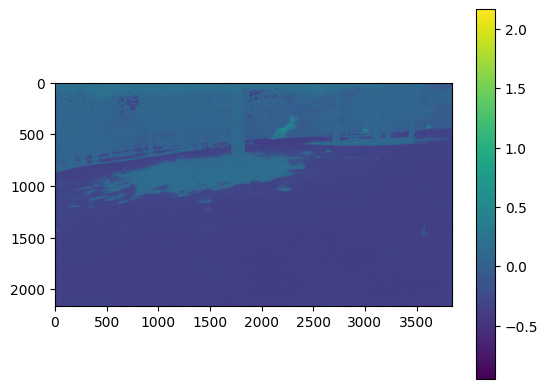

In [ ]:
# plotting the predicted masks
plt.imshow(s[0])
plt.colorbar()
print(np.max(s[0]))

In [ ]:
# predicting the mask of the first images using an untrained more complex U-Net model
w=model.predict(np.array([img_fire[0]]))
print(w.shape)

1/1 [==============================] - 55s 55s/step
(1, 2160, 3840, 1)


## Comment
There is a visible contrast between the fire pixel and its border.

In [ ]:
# In this section, I will tried to increase contrast between the fire pixel and its border pixel by first flattening the array into 1D.
# Looping through every element and setting a suitable threshold, I was able to achieve the higher contrast.
r=w[0]
d_f = r.flatten()
for i in range(len(d_f)):
    if d_f[i] < 0.1:
        d_f[i] = 1
    elif d_f[i] > 0.1:
        d_f[i] = 0


In [ ]:
d_f_r = np.reshape(d_f, (2160,3840,1))

In [ ]:
print(d_f_r[:,:,0].shape)

(2160, 3840)


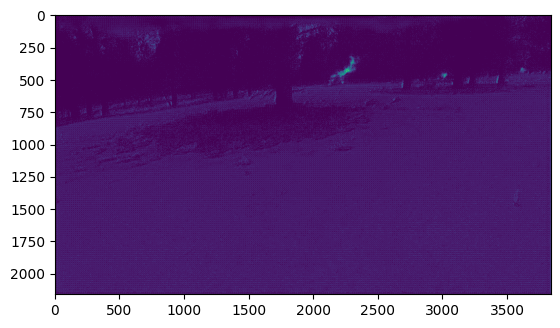

In [ ]:
plt.imshow(d_f_r[:,:,0])

## Comment on the predicted masks
The untrained model have located the fire pixel to a certain accuracy while the contrast between the background and the fire pixel is low.

## Further investigation
I could have use clustering technique which set a condition to only identify fire pixel batch if it is larger than a threshold area. This might help with enhancing the contrast between the fire and the background pixel.